In [1]:
import numpy as np
import fiona
import pprint
from madmex.models import PredictObject
from madmex.models import PredictClassification, Region
from madmex.util import chunk
import json
from shapely.geometry import shape, mapping
from rasterio.warp import transform_geom
from rasterio.crs import CRS
from affine import Affine
from rasterio.features import rasterize
import rasterio
from dask.distributed import Client
from rasterio.merge import merge
import os
from operator import itemgetter
from fiona.crs import to_string

In [2]:
#name of prediction

In [20]:
name_predict = 'lc_rf_poly_500_2k_min_thr_gr_s1_2_20m_res_10m_jalisco_2017'

In [21]:
qs_ids = PredictClassification.objects.filter(name=name_predict).distinct('predict_object_id')

In [22]:
len(qs_ids)

56

In [23]:
qs_ids[0]

<PredictClassification: PredictClassification object (18743040)>

In [24]:
list_ids = [x.predict_object_id for x in qs_ids]

In [25]:
region = 'Jalisco'

In [26]:
region_geom = Region.objects.get(name=region).the_geom
region_geojson = region_geom.geojson
geometry_region = json.loads(region_geojson)

In [9]:
shape_Jalisco=shape(geometry_region)

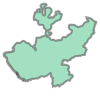

In [10]:
shape_Jalisco

In [68]:
def fun(id, path_fs, resolution):
    seg = PredictObject.objects.filter(id=id)
    path = seg[0].path
    poly = seg[0].the_geom
    poly_geojson = poly.geojson
    geometry_seg = json.loads(poly_geojson)
    segmentation_name_classified = path.split('/')[3].split('.')[0] + '_classified'
    with fiona.open(path) as src:
        crs = to_string(src.crs)
        shape_Jalisco_dc_tile = shape_Jalisco.intersection(shape(geometry_seg))
        geom_Jalisco_dc_tile_geojson = mapping(shape_Jalisco_dc_tile)
        shape_Jalisco_dc_tile_proj = shape(transform_geom(CRS.from_epsg(4326),
                                                          CRS.from_proj4(crs),
                                                          geom_Jalisco_dc_tile_geojson))
        pred_objects_sorted = PredictClassification.objects.filter(name=name_predict, predict_object_id=id).prefetch_related('tag').order_by('features_id')
        fc_pred=[(x['properties']['id'], x['geometry']) for x in src]
        fc_pred_sorted = sorted(fc_pred, key=itemgetter(0))
        fc_pred = [(x[0][1], 
                    x[1].tag.numeric_code) for x in zip(fc_pred_sorted, pred_objects_sorted)]
        fc_schema = {'geometry': 'Polygon',
                     'properties': {'code': 'int'}}
        #rasterize
        #geometry_seg_proj = geometry_transform(geometry_seg,crs_out=crs)
        geometry_seg_proj = transform_geom(CRS.from_epsg(4326),
                                           CRS.from_proj4(crs),
                                           geometry_seg)
        xmin, ymin, xmax, ymax = shape(geometry_seg_proj).bounds
        nrows = int(((ymax - ymin) // resolution) + 1)
        ncols = int(((xmax - xmin) // resolution) + 1)
        shape_dim = (nrows, ncols)
        arr = np.zeros((nrows, ncols), dtype=np.uint8)
        aff = Affine(resolution, 0, xmin, 0, -resolution, ymax)
        fc_pred_intersection = [(mapping(shape(feat[0]).intersection(shape_Jalisco_dc_tile_proj)),
                                     feat[1]) for feat in fc_pred if shape(feat[0]).intersects(shape_Jalisco_dc_tile_proj)]
        rasterize(shapes=fc_pred_intersection, transform=aff, dtype=np.uint8, out=arr)
        meta = {'driver': 'GTiff',
                'width': shape_dim[1],
                'height': shape_dim[0],
                'count': 1,
                'dtype': arr.dtype,
                'crs': crs,
                'transform': aff,
                'compress': 'lzw',
                'nodata': 0}
        filename = path_fs + segmentation_name_classified + '.tif'
        with rasterio.open(filename, 'w', **meta) as dst:
            dst.write(arr, 1)
    return filename

In [63]:
path_fs = '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/'

In [29]:
if not os.path.exists(path_fs):
    os.makedirs(path_fs)

In [30]:
scheduler_file= '/shared_volume/scheduler.json'

In [31]:
client = Client(scheduler_file=scheduler_file)

In [32]:
client

Client Scheduler: tcp://100.96.2.9:8786 Dashboard: http://100.96.2.9:8787/status,Cluster Workers: 3 Cores: 3 Memory: 30.00 GB


In [67]:
client.restart()

Client Scheduler: tcp://100.96.2.9:8786 Dashboard: http://100.96.2.9:8787/status,Cluster Workers: 3 Cores: 3 Memory: 30.00 GB


In [69]:
resolution = 10
c = client.map(fun,list_ids,**{'path_fs': path_fs,
                              'resolution': resolution})

In [70]:
result = client.gather(c)

In [71]:
result

['/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/529402_s2_10m_Jalisco_seg_2017_4try_sentinel_2_25_-27_2017_classified.tif',
 '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/7aef59_s2_10m_Jalisco_seg_2017_4try_sentinel_2_29_-32_2017_classified.tif',
 '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/0aa960_s2_10m_Jalisco_seg_2017_4try_sentinel_2_24_-32_2017_classified.tif',
 '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/823449_s2_10m_Jalisco_seg_2017_4try_sentinel_2_26_-27_2017_classified.tif',
 '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/0b7cb9_s2_10m_Jalisco_seg_2017_4try_sentinel_2_25_-30_2017_classified.tif',
 '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/4bd66d_s2_10m_Jalisco_seg_2017_4try_sentinel_2_22_-30_2017_classified.tif',
 '/shared_volume/tasks/2019/fiona_cloud_usage/using_rasterio_warp/5a1a11_s2_10m_Jalisco_seg_2017_4try_sentinel_2_25_-32_2017_classified.tif',
 '/sha

In [72]:
src_files_to_mosaic=[]

In [73]:
for file in result:
    src = rasterio.open(file)
    src_files_to_mosaic.append(src)

In [74]:
src.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6378137,6556752.316985585]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

In [75]:
mosaic, out_trans = merge(src_files_to_mosaic)

In [76]:
meta = {'driver': 'GTiff',
        'width': mosaic.shape[2],
        'height': mosaic.shape[1],
        'count': 1,
        'dtype': mosaic.dtype,
        'crs': src.crs,
        'transform': out_trans,
        'compress': 'lzw',
        'nodata': 0}

In [77]:
filename_mosaic = path_fs + 'mosaic_no_proj4_as_argument_classification.tif'

In [60]:
with rasterio.open(filename_mosaic, 'w', **meta) as dst:
    dst.write(mosaic)

In [61]:
#close & clean:
for ind in range(0,len(result)):
    src_files_to_mosaic[ind].close()
    os.remove(result[ind])